In [8]:
import matplotlib.pyplot as plt

import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
import os
import os.path as osp

# Data directories
checkpoints = '/kaggle/working/checkpoint/'
data_root = '/kaggle/input/birds23sp/birds'
training_dir = osp.join(data_root, "train/")
test_dir = osp.join(data_root, "test/")

# Use GPU if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

# Make checkpoint directory if it doesn't exist
if not osp.exists(checkpoints):
    os.makedirs(checkpoints)


cuda:0


In [20]:
# Maintenance shell commands
# !cd ../input/birds23sp/birds; ls
# !cd /kaggle/working/checkpoint/;ls; rm -rf *.pkl; ls

checkpoint-1.pkl  checkpoint-3.pkl  checkpoint-5.pkl
checkpoint-2.pkl  checkpoint-4.pkl  checkpoint-6.pkl


In [20]:
# Get dataloaders for the bird dataset
# Splits the data under 'training' directory into 80% training and 20% validation (test data)
# The actual test data for the competition comes from the 'test' directory
def get_bird_data():
    transform_train = transforms.Compose([
        transforms.Resize(256),
        transforms.RandomCrop(256, padding=8, padding_mode='edge'), # Take 256x256 crops from padded images
        transforms.RandomHorizontalFlip(),    # 50% of time flip image along y-axis
        transforms.RandomPerspective(distortion_scale=0.1, p=0.2), # Add perspective distortion
        transforms.ColorJitter(brightness=.1, contrast=.1, saturation=.1, hue=.1),  # Add color jitter to help mitigate overfitting
        transforms.ToTensor(),
    ])
    
    transform_test = transforms.Compose([
        transforms.Resize(256),
        transforms.ToTensor(),
    ])
    # Load all data
    fullset = torchvision.datasets.ImageFolder(root=training_dir, transform=transform_train)
    fullsetloader = torch.utils.data.DataLoader(fullset, batch_size=64, shuffle=True, num_workers=2)
    
    # Reserve some images in training directory for testing
    # https://stackoverflow.com/a/51768651
    train_size = int(0.8 * len(fullset))  # 80% for training
    test_size = len(fullset) - train_size  # Remaining 20% for testing
    
    trainset, testset = torch.utils.data.random_split(fullset, [train_size, test_size])
    
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True, num_workers=2)
    testloader = torch.utils.data.DataLoader(testset, batch_size=1, shuffle=False, num_workers=2)
    
    # Load actual test data
    actual_testset = torchvision.datasets.ImageFolder(root=test_dir, transform=transform_test)
    actual_testloader = torch.utils.data.DataLoader(actual_testset, batch_size=1, shuffle=False, num_workers=2)
    
    classes = open(osp.join(data_root,"names.txt")).read().strip().split("\n")
    class_to_idx = fullset.class_to_idx
    idx_to_class = {int(v): int(k) for k, v in class_to_idx.items()}
    idx_to_name = {k: classes[v] for k,v in idx_to_class.items()}
    return {'train': trainloader, 'test': testloader,'actual_test':actual_testloader, 'to_class': idx_to_class, 'to_name':idx_to_name}

data = get_bird_data()

# Print stats about the dataset
print(len(data['to_name']))
print("train size: ", len(data['train'].dataset))
print("test size: ", len(data['test'].dataset))

555
train size:  30849
test size:  7713


torch.Size([8, 3, 256, 256])


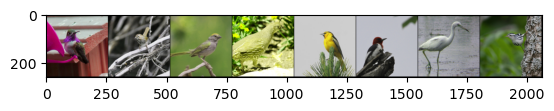

Labels:Calliope Hummingbird (Adult Male), Song Sparrow, Green-tailed Towhee, California Quail (Female/juvenile), Bullock's Oriole (Adult male), Red-headed Woodpecker (Adult), Little Blue Heron (Immature), Black-and-white Warbler


In [10]:
# Show sample image
dataiter = iter(data['train'])
images, labels = next(dataiter)
images = images[:8]
print(images.size())

def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print("Labels:" + ', '.join('%9s' % data['to_name'][labels[j].item()] for j in range(8)))

In [12]:
# Calculate prediction accuracy
def accuracy(net, dataloader):
  net.to(device)
  net.eval()
  correct = 0
  total = 0
  with torch.no_grad():
      for batch in dataloader:
          images, labels = batch[0].to(device), batch[1].to(device)
          outputs = net(images)
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()
  return correct/total

def smooth(x, size):
  return np.convolve(x, np.ones(size)/size, mode='valid')

In [13]:
# Trains a given network on a supplied dataset
def train(net, dataloader, epochs=1, start_epoch=0, lr=0.01, momentum=0.9, decay=0.0005, 
          verbose=1, print_every=10, state=None, schedule={}, checkpoint_path=None):
    net.to(device)
    net.train()
    losses = []
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(net.parameters(), lr=lr, momentum=momentum, weight_decay=decay)

    # Load previous training state
    if state:
        net.load_state_dict(state['net'])
        optimizer.load_state_dict(state['optimizer'])
        start_epoch = state['epoch']
        losses = state['losses']

    # Fast forward lr schedule through already trained epochs
    for epoch in range(start_epoch):
        if epoch in schedule:
            print ("Learning rate: %f"% schedule[epoch])
            for g in optimizer.param_groups:
                g['lr'] = schedule[epoch]

    for epoch in range(start_epoch, epochs):
        sum_loss = 0.0

        # Update learning rate when scheduled
        if epoch in schedule:
            print ("Learning rate: %f"% schedule[epoch])
            for g in optimizer.param_groups:
                g['lr'] = schedule[epoch]

        for i, batch in enumerate(dataloader, 0):
            inputs, labels = batch[0].to(device), batch[1].to(device)

            optimizer.zero_grad()

            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()  # autograd magic, computes all the partial derivatives
            optimizer.step() # takes a step in gradient direction

            losses.append(loss.item())
            sum_loss += loss.item()

            if i % print_every == print_every-1:    # print every 10 mini-batches
                if verbose:
                  print('[%d, %5d] loss: %.3f' % (epoch, i + 1, sum_loss / print_every))
                sum_loss = 0.0
        if checkpoint_path:
            state = {'epoch': epoch+1, 'net': net.state_dict(), 'optimizer': optimizer.state_dict(), 'losses': losses}
            torch.save(state, checkpoint_path + 'checkpoint-%d.pkl'%(epoch+1))
            
        if losses[-1] < 2:
            print("Epoch %i / %i"%(epoch, epochs))
            print("Train accuracy: %f"%accuracy(net, data['train']))
            print("Test accuracy: %f"%accuracy(net, data['test']))
    return losses

In [14]:
efficientnet = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_efficientnet_b0', pretrained=True)

# Number of feature going into the fully connected layer
fc_ins = efficientnet.classifier.fc.in_features

# __repr__ of the classifier layer of efficient net
# (classifier): Sequential(
#     (pooling): AdaptiveAvgPool2d(output_size=1)
#     (squeeze): Flatten()
#     (dropout): Dropout(p=0.2, inplace=False)
#     (fc): Linear(in_features=1280, out_features=1000, bias=True)
#   )

# Replace & reinitialize the fully connected layer with a new  
# one that has matching output for the number of bird classes
efficientnet.classifier.fc = nn.Linear(in_features=fc_ins, out_features =555, bias=True)


# Optionally resume from a previous checkpoint
cp = osp.join(checkpoints, "checkpoint-3.pkl")
if osp.exists(cp):
    state = torch.load(cp)
else:
    state = None
print("Loading from checkpoint?", state is not None)


/opt/conda/lib/python3.10/site-packages/torch/hub.py:286: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  warnings.warn(
Downloading: "https://github.com/NVIDIA/DeepLearningExamples/zipball/torchhub" to /root/.cache/torch/hub/torchhub.zip
/root/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub/PyTorch/Classification/ConvNets/image_classification/models/common.py:13: UserWarning: pytorch_quantization module not found, quantization will not be available
  warnings.warn

Loading from checkpoint? False


In [15]:
# training parameter
#  - learning rate schedule:
#           0.01 for epochs 0-3, 0.001 for epochs 4-6, 0.0001 for epochs 7-8
#  - weight decay: 0.0005
#  - momentum: 0.9
#  - batch size: 64
#  - epochs: 9
#  - optimizer: SGD
losses = train(efficientnet, data['train'], epochs=9, lr=.01,schedule={4:.001, 7:.0001}, print_every=20, state=state,checkpoint_path=checkpoints, decay=0.0005)

[0,    20] loss: 6.322
[0,    40] loss: 6.270
[0,    60] loss: 6.226
[0,    80] loss: 6.186
[0,   100] loss: 6.131
[0,   120] loss: 6.041
[0,   140] loss: 5.957
[0,   160] loss: 5.832
[0,   180] loss: 5.704
[0,   200] loss: 5.540
[0,   220] loss: 5.334
[0,   240] loss: 5.165
[0,   260] loss: 4.957
[0,   280] loss: 4.747
[0,   300] loss: 4.629
[0,   320] loss: 4.495
[0,   340] loss: 4.186
[0,   360] loss: 4.085
[0,   380] loss: 3.941
[0,   400] loss: 3.851
[0,   420] loss: 3.743
[0,   440] loss: 3.557
[0,   460] loss: 3.438
[0,   480] loss: 3.348
[1,    20] loss: 3.113
[1,    40] loss: 3.037
[1,    60] loss: 2.900
[1,    80] loss: 2.857
[1,   100] loss: 2.915
[1,   120] loss: 2.774
[1,   140] loss: 2.625
[1,   160] loss: 2.547
[1,   180] loss: 2.619
[1,   200] loss: 2.523
[1,   220] loss: 2.397
[1,   240] loss: 2.364
[1,   260] loss: 2.357
[1,   280] loss: 2.271
[1,   300] loss: 2.227
[1,   320] loss: 2.224
[1,   340] loss: 2.192
[1,   360] loss: 2.167
[1,   380] loss: 2.092
[1,   400] 

Testing  accuracy: 0.872638
Testing  accuracy: 0.737456


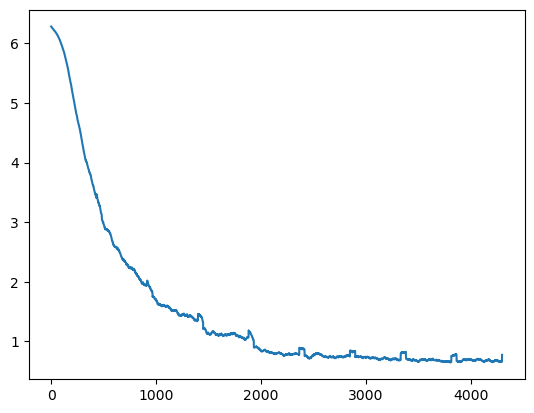

In [18]:
# Restore a previous checkpoint and test its accuracy
# state = torch.load(osp.join(checkpoints, "checkpoint-11.pkl"))

# resnet.load_state_dict(state['net'])
# optimizer = optim.SGD(resnet.parameters(), lr=0.001, momentum=0.9, weight_decay=0.005)
# optimizer.load_state_dict(state['optimizer'])
# losses = state['losses']
# print("Accuracy: ", accuracy(resnet, data['test']))

# Plot the training loss curve
plt.plot(smooth(losses,50))

# Calculate training & validation accuracy
print("Testing  accuracy: %f" % accuracy(efficientnet, data['train']))
print("Testing  accuracy: %f" % accuracy(efficientnet, data['test']))

In [21]:
# Performs prediction on a dataset and writes the results to a csv file
def predict(net, dataloader, ofname):
    out = open(ofname, 'w')
    out.write("path,class\n")
    net.to(device)
    net.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for i, (images, labels) in enumerate(dataloader, 0):
            if i%100 == 0:
                print(i)
            images, labels = images.to(device), labels.to(device)
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            fname, _ = dataloader.dataset.samples[i]
            out.write("test/{},{}\n".format(fname.split('/')[-1], data['to_class'][predicted.item()]))
    out.close()

# Predict on the actual test data for the competition
predict(efficientnet, data['actual_test'], "submission.csv")

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
